# Optimal pool table position
This is an interesting problem with a funny story attached to it. The problem is stated as follows: 
Suppose we have a pool table and a room. The pool table fits into the room but as you play you have to change normal pool cues for shorter ones as there is not enough space. At which position do we experience the maximal usability of the normal cues?

#### Approach
A computationally expensive solution that solves this problem quite well, is to simulate all possible positions and each time calculate how well the table is placed.

#### Input
As an input we get the size of the room, we assume that the walls have right angle between them. Also we get the size of the table or rather the size players need to play comfortably. 

#### Output
As you might have guessed, the output is the optimal position i.e. a triple (x,y,$\alpha$) where $\alpha \in [0,\pi)$ . $\alpha$ measures the angle between y-axis of the room coordinate system and y-axis of the table coordinate system.

First, we construct a method that checks if a point is inside the room. We also introduce a parameter called $P$. It stands for precision and specifies how many discrete points we consider and how big the error of our output is possibly going to be. Later, we will use it to optimize the search by slowly increasing this parameter as we get closer to the optimal position.

In [1]:
using Plots
# use gr as backend
gr();

# precision, 1 means 1 decimeters grid spacing, 10 means 1 cm grid spacing
const P = 1
# size of the room in decimeters is 43x42
const MAX_X = 43 
const MAX_Y = 42

# Constrains for ground, pr is an optional argument
function is_ground(point, pr = P)
    x, y = point
    return ! (( x < 0 || y < 0 ) || (x > MAX_X*pr || y > MAX_Y*pr) || 
                (  x < 1 * pr &&  y > 25 * pr && y < 32 * pr) || 
                (x > 27 * pr && x < 32 * pr && y < 10 * pr) || 
                (x >= 32 * pr && y < 8 * pr))
end
;

To check, if our representation of the ground is similar to the reality, we plot all the points we are about to work with.

In [2]:
function plot_ground(pr=P)
    x_ground = []
    y_ground = []
    
    for x in 0:(MAX_X*pr), y in 0:(MAX_Y*pr)
        if is_ground((x,y), pr)
            push!(x_ground, x)
            push!(y_ground, y)
        end
    end

    scatter(x_ground, y_ground, aspect_ratio=1, lab="ground", xlim=(-MAX_X*pr*0.05,MAX_X*pr*1.05), ylim=(-MAX_Y*pr*0.05,MAX_Y*pr*1.05))
end
;

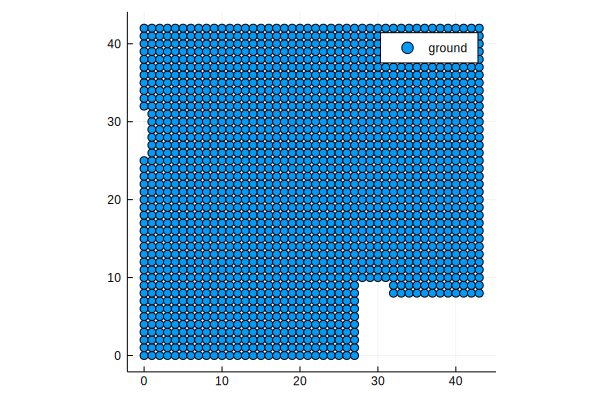

In [3]:
plot_ground()

Now, we define a table area to be the size of the table plus the area around that is needed to play comfortably. Further we define a table to be a triple (center_x, center_y, $\alpha$), which represents its position ( $\alpha \in [0,\pi)$ ).

In [4]:
const CUE_LENGTH = 12

# table area dimensions
TABLE_WIDTH = 12.6 
TABLE_LENGTH = 23

const TABLE_WIDTH_HALF = TABLE_WIDTH /2
const TABLE_LENGTH_HALF = TABLE_LENGTH /2

# is a point point inside the pool table?
function is_table(table, point, pr=P)
    center_x, center_y, α = table
    table_pos = [center_x, center_y]
    # translation
    point_trans = point - table_pos
    # rotation
    point_rot = [cos(α) -sin(α); sin(α) cos(α)] * point_trans
    
    # symmetry of the table around origin
    x = abs(point_rot[1])
    y = abs(point_rot[2])
    
    # Pythagoras theorem and constrains
    return ( x <= TABLE_WIDTH_HALF *pr && y <= (TABLE_LENGTH_HALF + CUE_LENGTH)* pr) ||
            ((x <= (TABLE_WIDTH_HALF + CUE_LENGTH)* pr) && y <=TABLE_LENGTH_HALF * pr) || 
            (x > TABLE_WIDTH_HALF * pr && y > TABLE_LENGTH_HALF * pr && 
            ( (x-TABLE_WIDTH_HALF * pr)^2 + (y-TABLE_LENGTH_HALF * pr)^2) <= (CUE_LENGTH * pr)^2)
end
;

In [5]:
function plot_table(table, pr=P)
    x_table = []
    y_table = []
    
    for x in 0:(MAX_X*pr), y in 0:(MAX_Y*pr)
        if is_table(table, [x, y], pr)
            push!(x_table, x)
            push!(y_table, y)
        end
    end
    scatter(x_table, y_table, aspect_ratio=1, lab="table area", xlim=(-MAX_X*pr*0.05,MAX_X*pr*1.05), ylim=(-MAX_Y*pr*0.05,MAX_Y*pr*1.05), color=2)
    # the middle is represented by a green dot
    scatter!([table[1]], [table[2]], label="", color=3)
end
;

We can now explore some positions of our pool table and more importantly make sure our functions work as expected.

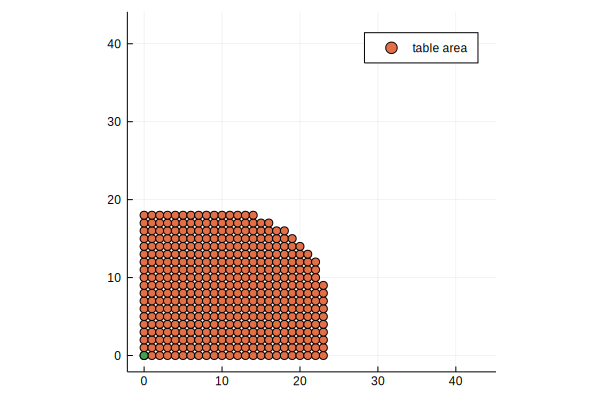

In [6]:
plot_table((0,0,π /2))

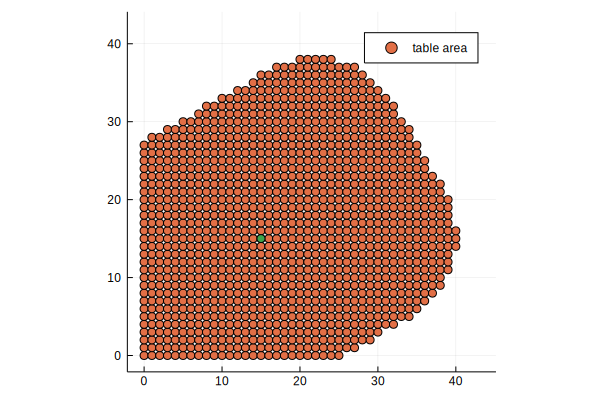

In [7]:
plot_table((15,15,π /3))

We can even plot ground and table areas simultaneously.

In [8]:
function plot_ground_table(table, pr=P)
    x_ground = []
    y_ground = []
    
    x_table = []
    y_table = []
    
    for x in 0:(MAX_X*pr), y in 0:(MAX_Y*pr)
        if is_ground((x,y),pr)
            push!(x_ground, x)
            push!(y_ground, y)
        end
        if is_table(table, [x, y], pr)
            push!(x_table, x)
            push!(y_table, y)
        end
    end

    scatter(x_ground, y_ground, aspect_ratio=1, lab="ground", xlim=(-MAX_X*pr*0.05,MAX_X*pr*1.05), ylim=(-MAX_Y*pr*0.05,MAX_Y*pr*1.05))
    scatter!(x_table, y_table, aspect_ratio=1, lab="table area", xlim=(-MAX_X*pr*0.05,MAX_X*pr*1.05), ylim=(-MAX_Y*pr*0.05,MAX_Y*pr*1.05), color=2)
    # middle represented by a green dot
    plt = scatter!([table[1]], [table[2]], label="", color=3)
    display(plt)
end
;

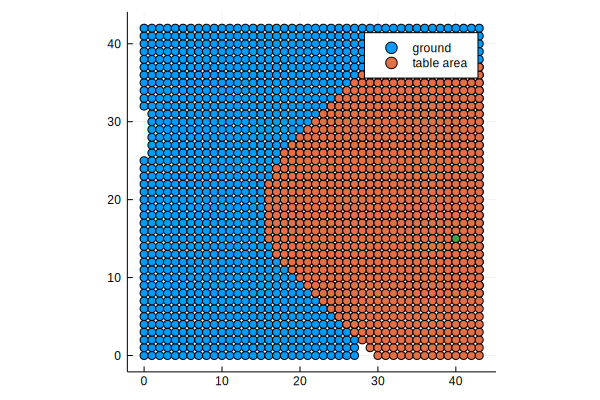

In [9]:
plot_ground_table((40,15,3 * π /4),)

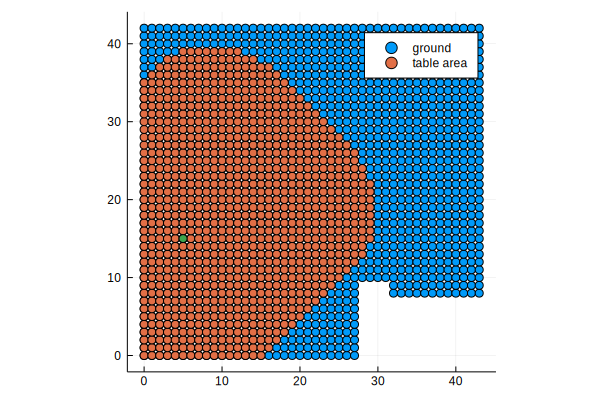

In [10]:
plot_ground_table((5,15, π /4))

We brutforce and check all the possible positions in our simplified world. We also define new parameter called SEARCH_RADIUS to limit possible positions. This parameter is linearly getting smaller in proportion to the precision. The best table is the one that has the biggest surface in the room. But before that, we need to define one last thing. And that is how many different values our angle $\alpha$ should take.

In [11]:
# search radius when the precision is 1
const SEARCH_RADIUS = 10
const NUM_α = 45

function search(pr=P, around_point=(MAX_X/2, MAX_Y/2))
    best_table = (0,0,0)
    best_metrics = 0

    # iterate over all positions of the table
    for x_t in 0:(MAX_X*pr), y_t in 0:(MAX_Y*pr)
        # in the circle around the point
        # radius=SEARCH_RADIUS / pr but we * by pr to scale it up again,
        # we set it up so that for pr=1 is radius = SEARCH_RADIUS
        if (x_t - around_point[1]*pr)^2 + (y_t - around_point[2]*pr)^2 < (SEARCH_RADIUS)^2
            # we could also check if x_t, y_t is in the room but our optimal solution 
            # should have its middle in the room...
            for α in 0.0:π/NUM_α:π
                # count how many points lie in the current table
                table = (x_t, y_t, α)
                metrics = sum([is_ground([x, y],pr) && is_table(table, [x, y],pr) ? 1 : 0 for x in 0:MAX_X*pr, y in 0:MAX_Y*pr])

                if metrics > best_metrics
                    best_metrics = metrics
                    best_table = table
                end
            end
        end
    end

    return (best_metrics, best_table)
end
;

In [12]:
@time result = search(1)

 14.897770 seconds (279.50 M allocations: 18.035 GiB, 18.51% gc time)


(1510, (21, 24, 1.4660765716752369))

So.. let's plot the result!

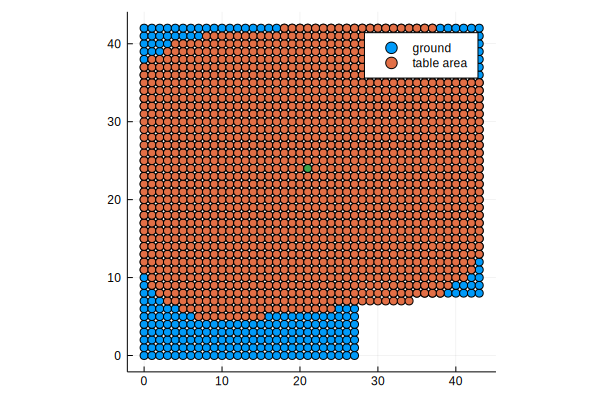

In [13]:
plot_ground_table(result[2])

In [14]:
[result[2][1], result[2][2], result[2][3] * 180 / π];

How about slowly changing the parameter $P$ as we get closer to the optimum? Each time we search with bigger precision but in always smaller area (defined by SEARCH_RADIUS / current precision).

In [15]:
function combined_search(pr_arr, plot=false)
    around_point_norm = (MAX_X/2, MAX_Y/2)
    result = (0,(0,0,0))
    for pr in pr_arr
        around_point = around_point_norm .* pr
        
        println("Precision: ", pr)
        @time result = search(pr, around_point)
        
        # normalize by dividing with pr
        around_point_norm = (result[2][1]/pr, result[2][2]/pr)
        println("Around point norm: ", around_point_norm, ", Current search radius used in search: ",SEARCH_RADIUS /pr)
        if plot
            plot_ground_table(result[2], pr)
        end
    end
    return result[2]
end
;

We stop at $P=1.2$ because it doesn't really make much of a difference for the end result and by definition of the radius, it might even happen that there are no points inside the circle for $P$ bigger. By the way, $P=1.2$ means that our grid has a unit spacing of about $8.33$ centimeters.

Precision: 0.4
  1.376390 seconds (37.73 M allocations: 1.605 GiB, 19.53% gc time)
Around point norm: 

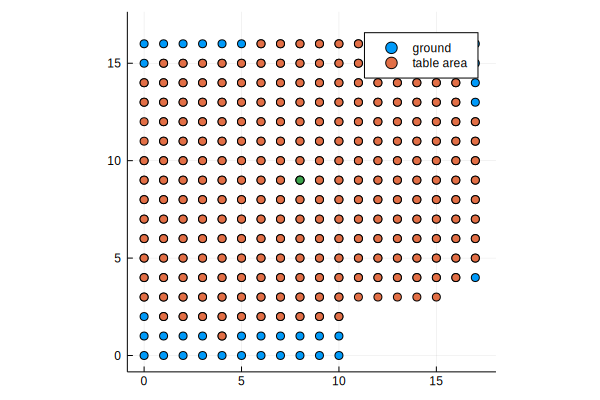

(20.0, 22.5), Current search radius used in search: 25.0
Precision: 0.8


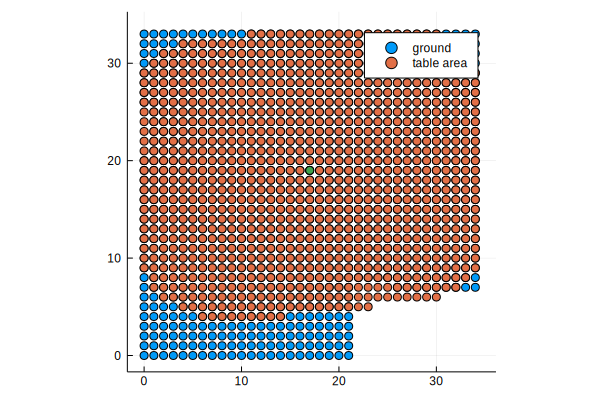

  8.741561 seconds (272.92 M allocations: 11.603 GiB, 20.01% gc time)
Around point norm: (21.25, 23.75), Current search radius used in search: 12.5
Precision: 1.0


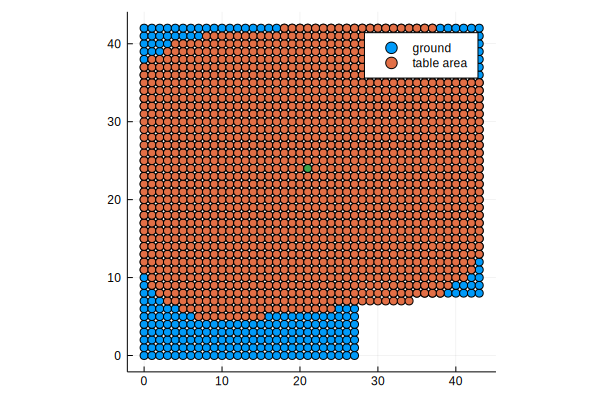

 13.981440 seconds (438.71 M allocations: 18.650 GiB, 20.10% gc time)
Around point norm: (21.0, 24.0), Current search radius used in search: 10.0
Precision: 1.2


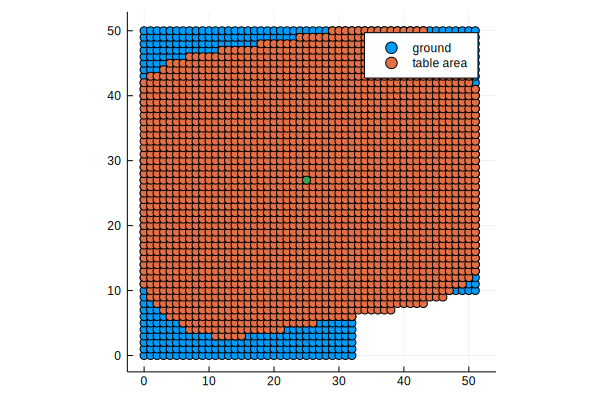

 21.062289 seconds (611.06 M allocations: 25.975 GiB, 21.81% gc time)
Around point norm: (20.833333333333336, 22.5), Current search radius used in search: 8.333333333333334
 46.713847 seconds (1.37 G allocations: 58.084 GiB, 20.42% gc time)


(25.0, 27.0, 1.3962634015954636)

In [16]:
@time res1 = combined_search([0.4,0.8,1,1.2], true)

Precision: 1.2
 

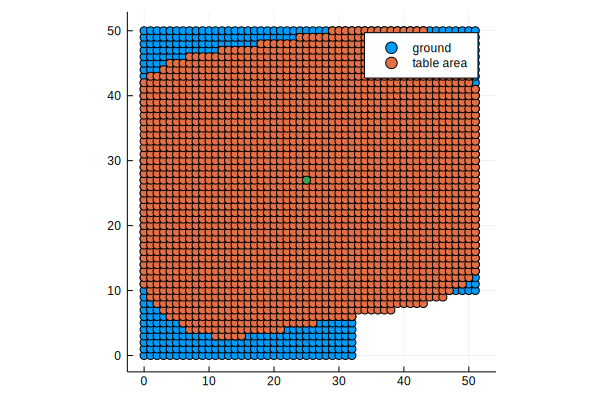

19.459476 seconds (603.33 M allocations: 25.646 GiB, 20.55% gc time)
Around point norm: (20.833333333333336, 22.5), Current search radius used in search: 8.333333333333334
 19.560068 seconds (603.67 M allocations: 25.661 GiB, 20.47% gc time)


(25.0, 27.0, 1.3962634015954636)

In [17]:
@time res2 = combined_search([1.2], true)

As we can see the first function call needed 45 seconds in total and the second one only 19 seconds. But the difference is that in the second call, we assumed that the optimal position is going to be around the middle with radius of $8.33$ cm. In the first call we started with a radius of $25$ cm and slowly excluded solutions that are not relevant.

The funny story behind this project is, that after I wrote this code, I realized there is a fixed lamp hanging over the table. And of course moving that lamp would be a huge amount of effort ... so at the end the pool table stayed where it initially was.

Thanks for reading.